# Train Whale Detection

In [3]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

#Classes
from utils import RoboflowHelper
#Functions
from utils import calculate_bounding_box, crop_image, find_rotation_angle, rotate_image, centre_image

## Read Data

In [4]:
# Path to the image directory and CSV file
image_dir = "./data/imgs"
csv_file = "./data/train.csv"

# Reading the CSV file using Pandas
data = pd.read_csv(csv_file)

In [5]:
data.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


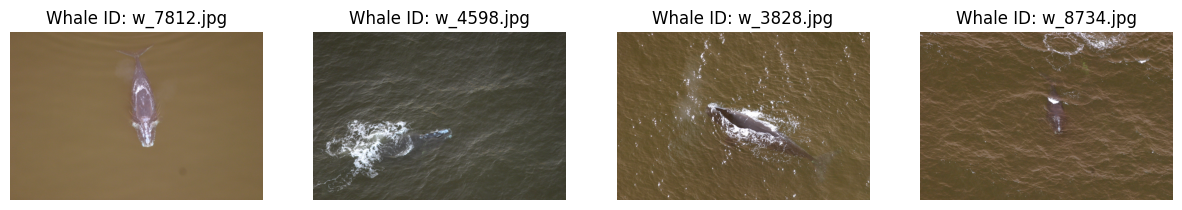

In [6]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = data['Image'].values[i]
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Whale ID: {image_name}")
        axes[i].axis('off')

plt.show()

## Import pretrained YOLOv5 Model

In [7]:
rfh = RoboflowHelper()

loading Roboflow workspace...
loading Roboflow project...


### Display Boundingboxes

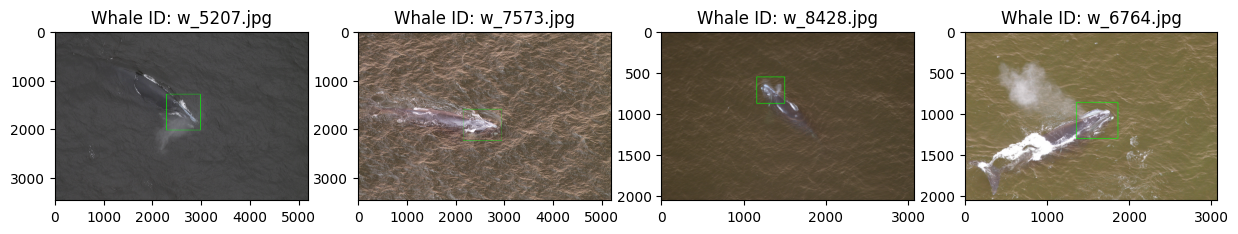

In [8]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    # visualize your prediction
    index = 300 + i
    image_name = data['Image'].values[index]
    image_path = os.path.join(image_dir, data['Image'][index])
    prediction = rfh.get_prediction(image_path)
    if prediction:
        image = cv2.imread(image_path)
        start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
        cv2.rectangle(image, start_point, end_point, color=(0,255,0), thickness=6)
        axes[i].imshow(image)
        axes[i].set_title(f"Whale ID: {image_name}")

plt.show()

### Read Annotaded Data

In [9]:
with open("./data/annotations/headtips.json") as f:
    headtips = json.load(f)

with open("./data/annotations/blowholes.json") as f:
    blowholes = json.load(f)

In [10]:
headtips[0]

{'annotations': [{'class': 'point',
   'x': 1361.8785425101214,
   'y': 864.3886639676114}],
 'class': 'image',
 'filename': 'w_1.jpg'}

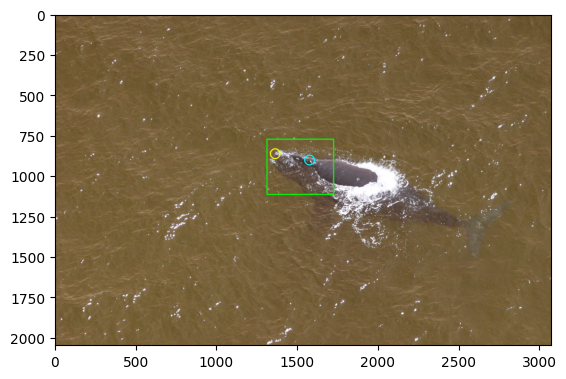

In [11]:
image_name = headtips[0]['filename']
x1 = int(headtips[0]['annotations'][0]['x'])
y1 = int(headtips[0]['annotations'][0]['y'])
x2 = int(blowholes[0]['annotations'][0]['x'])
y2 = int(blowholes[0]['annotations'][0]['y'])
image_path = os.path.join(image_dir, image_name)
prediction = rfh.get_prediction(image_path)
if prediction:
    image = cv2.imread(image_path)
    start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
    cv2.circle(image, (x1, y1), 30, color=(255,255,0), thickness=6)
    cv2.circle(image, (x2, y2), 30, color=(0,255,255), thickness=6)
    cv2.rectangle(image, start_point, end_point, color=(0,255,0), thickness=6)
    plt.imshow(image)

### Rotate and Centre Images

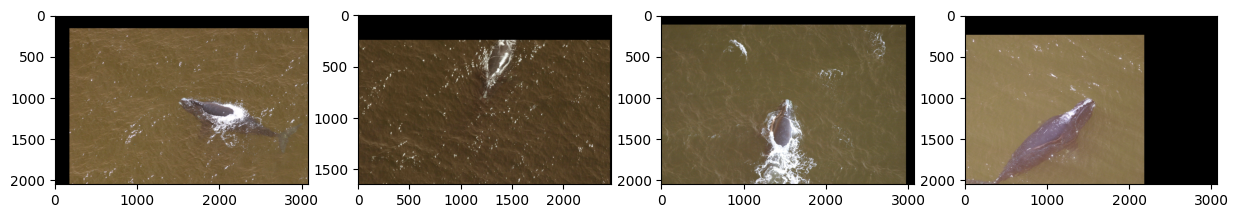

In [14]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    centred_image = centre_image(image, x1, y1)
    axes[i].imshow(centred_image)

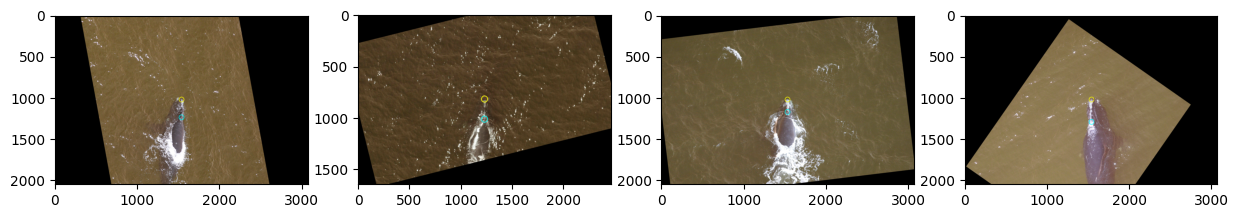

In [15]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    
    rotation_angle = find_rotation_angle(x1, y1, x2, y2)
    cv2.circle(image, (x1, y1), 30, color=(255,255,0), thickness=6)
    cv2.circle(image, (x2, y2), 30, color=(0,255,255), thickness=6)
    centred_image = centre_image(image, x1, y1)
    rotated_image = rotate_image(centred_image, rotation_angle) 
    
    axes[i].imshow(rotated_image)

### Crop images

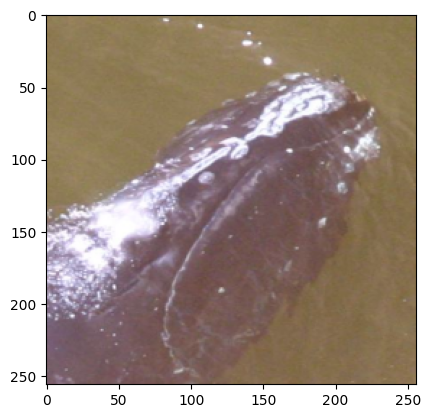

In [16]:
prediction = rfh.get_prediction(image_path)
if prediction:
    image = cv2.imread(image_path)
    start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
    cropped = crop_image(image, start_point, end_point)
    resized = cv2.resize(cropped, (256,256), interpolation = cv2.INTER_AREA)
    plt.imshow(resized)

## Prepare Testdata

In [15]:
# to not accidentally run the following code
throw Exception

SyntaxError: invalid syntax (2104500626.py, line 2)

### Rotation Network

In [19]:
IMAGE_DIMENSIONS = (512,512)

In [45]:
input_path = "./data/imgs"
output_path = "./data/cropped"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        prediction = rfh.get_prediction(image_path)
        if prediction:
            image = cv2.imread(image_path)
            start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
            cropped = crop_image(image, start_point, end_point)
            resized = cv2.resize(cropped, IMAGE_DIMENSIONS, interpolation = cv2.INTER_AREA)
            cv2.imwrite(os.path.join(output_path, image_name), resized)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [32]:
input_path = "./data/imgs"

rotation_angles = {}

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        x1 = int(headtips[i]['annotations'][0]['x'])
        y1 = int(headtips[i]['annotations'][0]['y'])
        x2 = int(blowholes[i]['annotations'][0]['x'])
        y2 = int(blowholes[i]['annotations'][0]['y'])
        if x1 and y1 and x2 and y2:
            rotation_angle = find_rotation_angle(x1, y1, x2, y2)
            rotation_angles[image_name] = ("%.2f" % rotation_angle)


In [44]:
pd.Series(rotation_angles, name='rotation_angle').to_csv('./data/rotation_angles.csv')

### Prediction Network

In [ ]:
input_path = "./data/imgs"
output_path = "./data/rotated"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    x1 = int(headtips[i]['annotations'][0]['x'])
    y1 = int(headtips[i]['annotations'][0]['y'])
    x2 = int(blowholes[i]['annotations'][0]['x'])
    y2 = int(blowholes[i]['annotations'][0]['y'])
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path) and not os.path.exists(os.path.join(output_path, image_name))
        image = cv2.imread(image_path)
        if image is not None and x1 and y1 and x2 and y2:
            rotation_angle = find_rotation_angle(x1, y1, x2, y2)
            centred_image = centre_image(image, x1, y1)
            rotated_image = rotate_image(centred_image, rotation_angle) 
            cv2.imwrite(os.path.join(write_path, image_name), rotated_image)

In [28]:
input_path = "./data/rotated"
output_path = "./data/rotated_cropped"

for i in range(len(headtips)):
    image_name = headtips[i]['filename']
    image_path = os.path.join(input_path, image_name)
    if os.path.exists(image_path):
        prediction = rfh.get_prediction(image_path)
        if prediction:
            image = cv2.imread(image_path)
            start_point, end_point = calculate_bounding_box(prediction['x'], prediction['y'], prediction['width'], prediction['height'])
            cropped = crop_image(image, start_point, end_point)
            resized = cv2.resize(cropped, IMAGE_DIMENSIONS, interpolation = cv2.INTER_AREA)
            cv2.imwrite(os.path.join(output_path, image_name), resized)

3400: w_7408.jpg
3401: w_7409.jpg
3403: w_7412.jpg
3405: w_7415.jpg
3406: w_7416.jpg
3407: w_7417.jpg
3409: w_742.jpg
3410: w_7422.jpg
3411: w_7423.jpg
3412: w_7424.jpg
3413: w_7425.jpg
3414: w_7426.jpg
3415: w_743.jpg
3416: w_7430.jpg
3418: w_7438.jpg
3419: w_7439.jpg
3420: w_7440.jpg
3422: w_7444.jpg
3423: w_7446.jpg
3424: w_7447.jpg
3425: w_7449.jpg
3426: w_7450.jpg
3427: w_7452.jpg
3428: w_7455.jpg
3429: w_7458.jpg
3430: w_7459.jpg
3432: w_7460.jpg
3433: w_7462.jpg
3434: w_7464.jpg
3435: w_7465.jpg
3436: w_7466.jpg
3437: w_7467.jpg
3438: w_7470.jpg
3439: w_7471.jpg
3440: w_7473.jpg
3441: w_7474.jpg
3442: w_7476.jpg
3443: w_7477.jpg
3444: w_7482.jpg
3447: w_7494.jpg
3448: w_7497.jpg
3449: w_7498.jpg
3450: w_7499.jpg
3451: w_75.jpg
3452: w_7501.jpg
3453: w_7502.jpg
3454: w_7503.jpg
3455: w_7504.jpg
3456: w_7505.jpg
3458: w_751.jpg
3459: w_7510.jpg
3460: w_7511.jpg
3461: w_7513.jpg
3462: w_7516.jpg
3463: w_7518.jpg
3464: w_7519.jpg
3465: w_752.jpg
3466: w_7520.jpg
3467: w_7521.jpg
346